## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library import *

L2  : 9.689849562507341e-11
Linf: 4.760858929309109e-10


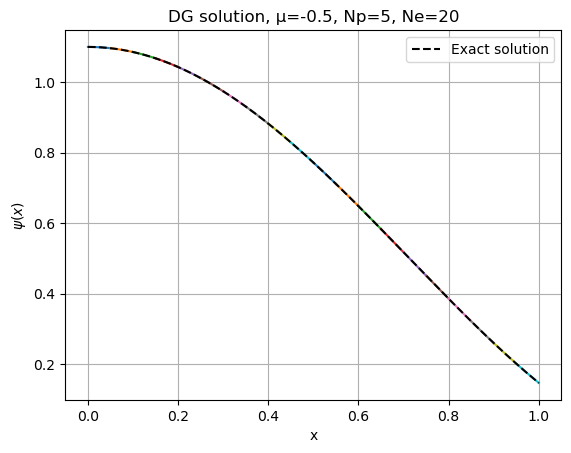

In [2]:
# ─── Example usage (Simple DG) ───

# Parameters for the transport problem
μ      = -0.5
ψ_MMS  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
σ_t    = lambda x: x**2 + 1
source = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow = lambda x: ψ_MMS(x)

# Mesh parameters
Np = 5                        # Legendre polynomials per element (basis size)
Ne = 20
xs = np.linspace(0, 1, Ne + 1) # Mesh points / element boundaries

# Solve
ψ_weights = transport_direct_solve(μ, σ_t, source, inflow, Np, xs)
# ψ_weights = transport_direct_solve(μ, σ_t, compute_source_term(source, Np, xs), inflow, Np, xs)
# ψ_weights = ψ_weights.reshape(Ne, Np)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights, xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights, xs, Np, ψ_MMS, p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\jdnyt\AppData\Local\Temp\ipykernel_28348\3510351954.py:9: RuntimeWarning: invalid value encountered in scalar divide
  - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ψ_MMS(x,μ) / (μ**2)
 13%|█▎        | 2/15 [00:00<00:01, 11.20it/s]

Convergence check: nan
Convergence check: nan
Convergence check: nan


 40%|████      | 6/15 [00:00<00:00, 11.31it/s]

Convergence check: nan
Convergence check: nan
Convergence check: nan


 53%|█████▎    | 8/15 [00:00<00:00, 11.36it/s]

Convergence check: nan
Convergence check: nan
Convergence check: nan


 80%|████████  | 12/15 [00:01<00:00, 11.41it/s]

Convergence check: nan
Convergence check: nan
Convergence check: nan


100%|██████████| 15/15 [00:01<00:00, 11.36it/s]

Convergence check: nan
Convergence check: nan
Convergence check: nan
Chosen μ: 0.5384693101056831
L2  : nan
Linf: 0.0


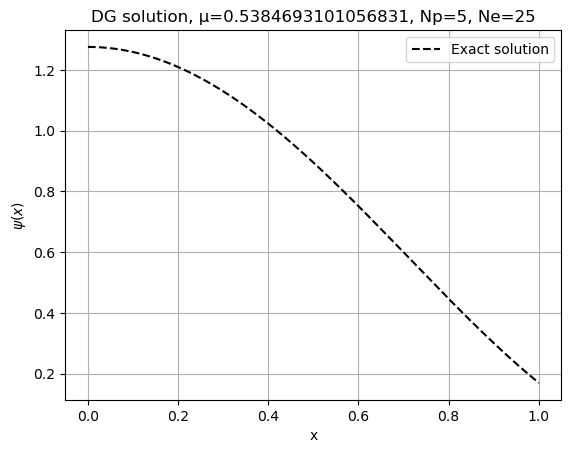

In [ ]:
# ─── Example usage (Fixed point iteration) ───

# Parameters for the transport problem
ψ_MMS  = lambda x,μ: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactured solution
σ_t    = lambda x: x**2 + 1
σ_a    = lambda x: x**2 + 1
ε      = 1
source = lambda x,μ: (μ**3)/ε * (2*x - 6.8*np.sin(2*x)) + (σ_t(x)/ε**2 * ψ_MMS(x,μ)) \
                   - (σ_t(x)/ε - ε*σ_a(x)) / (3*ε) * ((x**2 +1) + 3.4*np.cos(2*x))
inflow = lambda x,μ: ψ_MMS(x,μ)
 
# Mesh parameters
Np = 5                      # Legendre polynomials per element (basis size)
Nμ = 5                      # Legendre polynomials per element (basis size)
Nt = 15                      # Legendre polynomials per element (basis size)
xs = np.linspace(0, 1, 26) # Mesh points / element boundaries
Ne = len(xs) - 1

# Solve
ψ_weights_all, μs = transport_direct_solve_diffusive(σ_t, σ_a, ε, source, inflow, Np, Nμ, Nt, xs)
μi = 3 # Chosen μ for the error calculation
μc = μs[μi]
print("Chosen μ:", μc)

ξ_μ, w_μ = gausslegendre(Nμ)
φ = (w_μ.reshape((-1, 1)) * ψ_weights_all.reshape((Nμ, Ne*Np))).sum(axis=0)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p=2))
print("Linf:",error_Lp(ψ_weights_all[μi,:,:], xs, Np, lambda x: ψ_MMS(x,μc), p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights_all[μi,:,:], xs, Np, μ=μc, exact_ψ_func=lambda x: ψ_MMS(x,μc))

In [4]:
ψ_weights.reshape((3,100)).shape

(3, 100)

In [5]:
A = np.array([1,2,3])
B = np.ones((3, 4))
(A.reshape((-1, 1))*B).sum(axis=0)

array([6., 6., 6., 6.])